In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import cv2
import random
import glob
import json

In [3]:
import sys
sys.path.append('../')

In [4]:
from dataset import tuSimpleDataset
from torch.utils.data import DataLoader
from segnet import SegNet

In [5]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs

### Data load

In [6]:
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 2
BATCH_SIZE = 8
SIZE = [224, 224]

In [7]:
train_path = '/data/tuSimple/train_set/'
test_path = '/data/tuSimple/test_set/'
MODEL_PATH = './model_best.pth'

In [8]:
train_dataset = tuSimpleDataset(train_path, size=SIZE)
test_dataset = tuSimpleDataset(test_path, size=SIZE, trans=False)

In [9]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=8)

In [10]:
imgs, label_imgs = next(iter(train_dataloader))

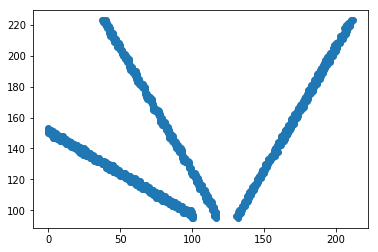

In [11]:
idx = np.random.randint(0, BATCH_SIZE-1)
lane_coordinate = np.where(label_imgs[idx] == 1)
plt.scatter(lane_coordinate[1], lane_coordinate[0])

In [12]:
idxT = np.transpose(lane_coordinate)

### DBSCAN

In [13]:
db = DBSCAN(eps=2).fit(idxT)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

set(labels)

{0, 1, 2}

In [14]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

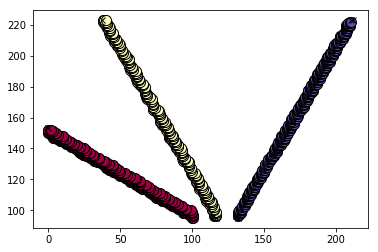

In [15]:
xys = []
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    
    xy = idxT[class_member_mask & core_samples_mask]
    xy2 = np.vstack((xy[:,1], xy[:,0])).T
    xys.append(xy2)
    
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)
    
    xy = idxT[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'x', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

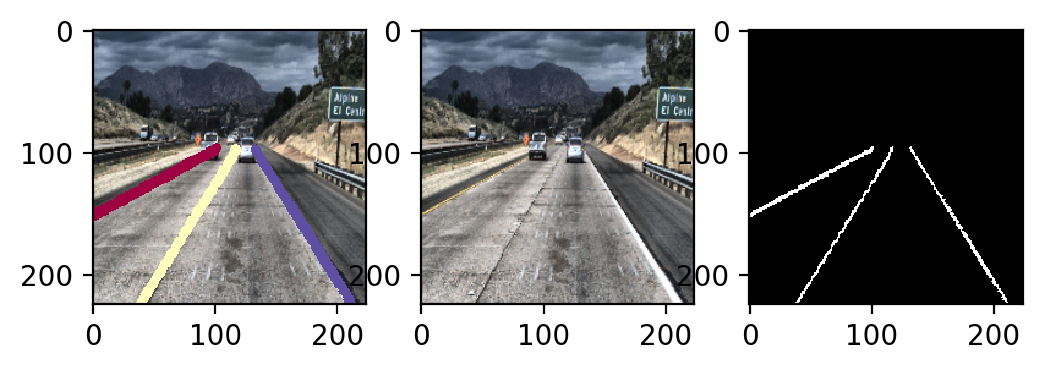

In [16]:
img = np.transpose(imgs[idx].cpu().numpy(), (1,2,0))
out_label = img.copy()
for xy, col in zip(xys, colors):
    cv2.polylines(out_label, np.int32([xy]), isClosed=False, color=tuple(col), thickness=5)

plt.figure(dpi=200)
plt.gray()
plt.subplot(131);plt.imshow(out_label)
plt.subplot(132);plt.imshow(img)
plt.subplot(133);plt.imshow(label_imgs[idx].cpu().numpy())